In [1]:
import cv2
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

画像サイズの比率をあわせるクロップ量の計算

$\frac{1920}{1080} = \frac{1616+x}{872}$

$\frac{1920}{1080} - \frac{1616}{872} = \frac{x}{872}$

$x = \{ \frac{1920}{1080} - \frac{1616}{872} \} 872$

$x = 65.77$

In [2]:
def show_cv_image(img):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # remove unnecessary ticks
    plt.axis("off")
    plt.imshow(rgb_img)
    
# convert raw input to FHD size
# This is not required once conversion done.
width_crop = 65.77777777
width_crop_half = int(width_crop // 2)
input_img = cv2.imread("height866_pitch60.bmp")
input_img = input_img[width_crop_half:input_img.shape[0]+width_crop_half, :, :] # crop letter box
input_img = cv2.resize(input_img, (1920,1080))

topview_img = cv2.imread("height2000_pitch90.bmp")
topview_img = topview_img[width_crop_half:topview_img.shape[0]+width_crop_half, :, :] # crop letter box
topview_img = cv2.resize(topview_img, (1920,1080))

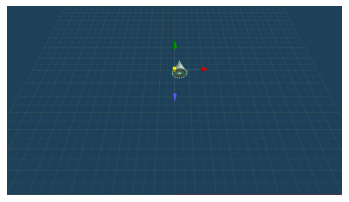

In [3]:
show_cv_image(input_img)

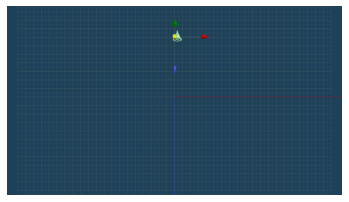

In [4]:
show_cv_image(topview_img)

In [5]:
# Rotation: Camera pose, rotate object axis to camera frame. 
R1 = Rotation.from_euler("xyz", [60, 0, 0], degrees=True).as_matrix()
R2 = Rotation.from_euler("xyz", [90, 0, 0], degrees=True).as_matrix()
# Translation: t1 and t2 on the camera coordiate respectively, from object axis to camera frame.
t1 = R1 @ np.array([0, -0.866, 0]).reshape((3, 1))
t2 = R2 @ np.array([0, -2.000, 0]).reshape((3, 1))

R12 = R2 @ R1.T
t12 = R2 @ (- R1.T @ t1) + t2
# Plane normal vector at camera 1 cooridinate. here, object axis -> camera frame.
n = np.array([0, 1, 0]).reshape((3, 1))
n1 = R1 @ n
# d is distance from plane to t1.
d = np.linalg.norm(n1.dot(t1.T))

{
    "R12": Rotation.from_matrix(R12).as_euler("xyz", degrees=True),
    "t12": t12,
    "t1": t1,
    "t2": t2,
    "norm(t12)": np.linalg.norm(t12),
    "n1": n1,
    "distance": d,
}

{'R12': array([30.,  0.,  0.]),
 't12': array([[ 0.00000000e+00],
        [ 4.88505296e-21],
        [-1.13400000e+00]]),
 't1': array([[ 0.      ],
        [-0.433   ],
        [-0.749978]]),
 't2': array([[ 0.],
        [ 0.],
        [-2.]]),
 'norm(t12)': 1.1340000000000001,
 'n1': array([[0.       ],
        [0.5      ],
        [0.8660254]]),
 'distance': 0.8660000000000001}

#### Homogray equation

In [6]:
Hab = R12 - ((t12 @ n1.T) / d)
Hab / Hab[2, 2]

array([[ 0.49998533,  0.        ,  0.        ],
       [ 0.        ,  0.433     , -0.24999267],
       [ 0.        ,  0.57735027,  1.        ]])

#### FoV からカメラマトリックス計算

https://stackoverflow.com/questions/39992968/how-to-calculate-field-of-view-of-the-camera-from-camera-intrinsic-matrix

In [7]:
def fov_to_focal_1(fov_deg, length):
    fov = fov_deg / 180.0 * np.pi 
    focal = length/2 / np.tan(fov/2)
    return focal

def fov_to_camera_matrix(fov_deg, image_size):
    w, h = image_size[0], image_size[1]
    length = min(h, w)
    f = fov_to_focal_1(fov_deg, length)
    fx, fy = f, f
    K = np.array([
        [fx, 0, w /2],
        [0, fy, h /2],
        [0, 0, 1],
    ])
    return K

[[935.30743609   0.         960.        ]
 [  0.         935.30743609 540.        ]
 [  0.           0.           1.        ]]
[[ 7.49978000e-01  8.88888889e-01  2.40021120e+02]
 [ 0.00000000e+00  1.14950000e+00 -1.61460000e+02]
 [ 0.00000000e+00  9.25925926e-04  1.00000000e+00]]


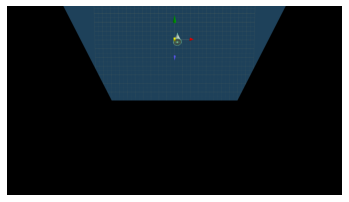

In [8]:
fov_deg = 60.0
dsize = (input_img.shape[1], input_img.shape[0])
K = fov_to_camera_matrix(fov_deg, dsize)
P = K.copy()
P[0,0] *= 1
P[1,1] *= 1
print(K)
H = P @ Hab @ np.linalg.inv(K)
H /= H[2,2]
print(H)
perspective_img = cv2.warpPerspective(input_img, H, dsize)
show_cv_image(perspective_img)

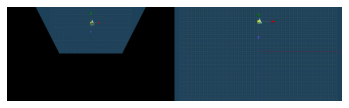

In [9]:
result_img = np.hstack([perspective_img, topview_img])
show_cv_image(result_img)

[[935.30743609   0.         960.        ]
 [  0.         935.30743609 540.        ]
 [  0.           0.           1.        ]]


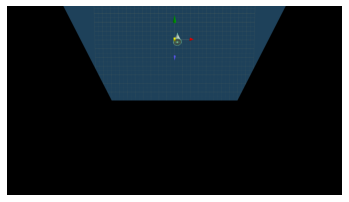

In [10]:
fov_deg = 60.0
dsize = (input_img.shape[1], input_img.shape[0])
K = fov_to_camera_matrix(fov_deg, dsize)
P = K.copy()
P[0,0] *= 1
P[1,1] *= 1
print(K)
map1, map2 = cv2.initUndistortRectifyMap(K, None, Hab, P, dsize, cv2.CV_16SC2)
perspective_img = cv2.remap(input_img, map1, map2, cv2.INTER_LINEAR)
show_cv_image(perspective_img)

#### Apply only rotaton from camera1 to camera2

remains camera1 position but apply angle rotation from camera 1 to camera 2.
The plane is visible, the object is not visible.

[[935.30743609   0.         960.        ]
 [  0.         935.30743609 540.        ]
 [  0.           0.           1.        ]]


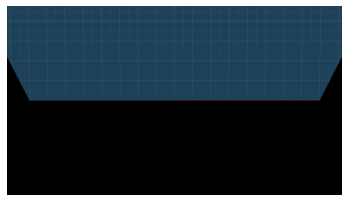

In [11]:
fov_deg = 60.0
dsize = (input_img.shape[1], input_img.shape[0])
K = fov_to_camera_matrix(fov_deg, dsize)
P = K.copy()
## comment in below to show object by changing projection FoV
#P[0,0] *= 0.50
#P[1,1] *= 0.50
#P[1,2] = 540
print(K)
map1, map2 = cv2.initUndistortRectifyMap(K, None, R12, P, dsize, cv2.CV_16SC2)
perspective_img = cv2.remap(input_img, map1, map2, cv2.INTER_LINEAR)
show_cv_image(perspective_img)

In [12]:
def homography_camera_displacement(R1, R2, t1, t2, n1):
    """
    Calculate homography matrix for camera displacement c1 to c2.
    
    Args:
      R1: Rotation matrix for camera1
      R2: Rotation matrix for camera2
      t1: Translation vector for camera1
      t2: Translation vector for camera2
      n1: normal vector for projection plane on camera1 coordinate
    
    Return:
      Hab: homography matrix for camera displacement from 1 to 2.
    """
    R12 = R2 @ R1.T
    t12 = R2 @ (- R1.T @ t1) + t2
    # d is distance from plane to t1.
    d = np.linalg.norm(n1.dot(t1.T))

    H12 = R12 - ((t12 @ n1.T) / d)
    H12 /= H12[2,2]
    return H12


### カメラ位置の移動によって出力位置も変わる

In [13]:
# Camera pose, from object axis to camera frame.
R1 = Rotation.from_euler("xyz", [60, 0, 0], degrees=True).as_matrix()
R2 = Rotation.from_euler("xyz", [90, 0, 0], degrees=True).as_matrix()
# t1 and t2 on the camera coordiate respectively, from object axis to camera frame.
# Here, t2 is moved to +(1, 0, 1).
t1 = R1 @ np.array([0, -0.866, 0]).reshape((3, 1))
t2 = R2 @ (np.array([0, -2.000, 0]) + np.array([1.0, 0.0, 1.0])).reshape((3, 1))
# normal vector at camera 1 cooridinate. here, object axis -> camera frame
n = np.array([0, 1, 0]).reshape((3, 1))
n1 = R1 @ n

H12 = homography_camera_displacement(R1, R2, t1, t2, n1)

[[ 7.49978000e-01  4.55876187e-01 -2.27632598e+02]
 [ 0.00000000e+00  1.58251270e+00  3.06193718e+02]
 [ 0.00000000e+00  9.25925926e-04  1.00000000e+00]]


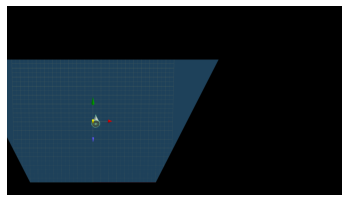

In [14]:
fov_deg = 60.0
dsize = (input_img.shape[1], input_img.shape[0])
K = fov_to_camera_matrix(fov_deg, dsize)
P = K.copy()
H = P @ H12 @ np.linalg.inv(K)
H /= H[2,2]
print(H)
perspective_img = cv2.warpPerspective(input_img, H, dsize)
show_cv_image(perspective_img)